<a href="https://colab.research.google.com/github/Alejandro-ZZ/Deep-Learning/blob/master/Denoising_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Denoising Autoencoder**

* Application of the architecture of an Autoencoder using convolutional neural networks to remove noise in images. 

* The Fashion MNIST dataset is used and noisy images are generated by adding Gaussian noise to the train images.

## **1. Libraries**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.utils
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import FashionMNIST

## **2. Training hyperparameters**

In [ ]:
# Size of the "Bottleneck" that contains the 
# compressed representation of the input data
latent_dims = 10

# Forward and backward pass of ALL training samples
num_epochs = 50

# Number of training samples in one forward and backward pass
batch_size = 128

# Number of channels produced by the first convolution
capacity = 64

# Step size at each iteration while moving toward a 
# minimum of a loss function
learning_rate = 1e-3

# Factor to add noise to images
noise_factor = 0.4

# Wether to use or not GPU
use_gpu = True

## **3. Fashion MNIST Dataset**

Fashion-MNIST has a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes: 

1. Top/T-shirt
2. Trouser
3. Pullover
4. Dress
5. Coat
6. Sandar
7. Shirt
8. Sneaker
9. Bag
10. Anckle Boot.

In [ ]:
# Create a list with multiple transforms together
img_transform = transforms.Compose([

    transforms.ToTensor(), # Convert to a torch.FloatTensor of shape (Channel, Height, Width) 
                           # and scale them in the range [0.0, 1.0] if dtype = np.uint8

    transforms.Normalize(mean=(0.5,), std=(0.5,)) # image = (image - mean) / std
])

# Download train/test datasets
train_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=True, transform=img_transform)
test_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=False, transform=img_transform)

# Generate an iterable over the given dataset
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



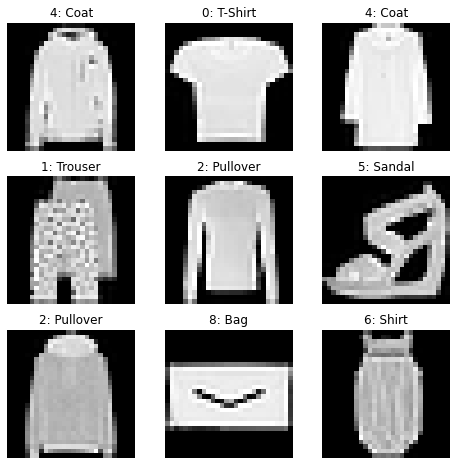

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()

    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)

    plt.title(f'{label}: {labels_map[label]}')
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()

## **4. Autoencoder architecture**

A convolutional encoder/decoder architecture is used. The channels of the convolutional layer increase as the process approaches the  "bottleneck", but the number of features is reduced. This is because while the number of channels is increased by a factor of two, the latent dimensions are reduced by a factor of 4.

**Reference:** [Deconvolution and Checkerboard Artifacts](https://distill.pub/2016/deconv-checkerboard/)

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        # Two convolutional layers + one fully connected
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=capacity, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=capacity, out_channels=capacity*2, kernel_size=4, stride=2, padding=1)
        self.fc1 = nn.Linear(in_features=capacity*2*7*7, out_features=latent_dims)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))   # Convolution 1 + ReLU
        x = F.relu(self.conv2(x))   # Convolution 2 + ReLU

        # Show Height and Width after the second convolution
        # print("Encoder Conv2 output:", x.size())

        x = x.view(x.size(0), -1)   # Reshape to (batch, channels x height x width)
        x = self.fc1(x)             # Fully connected
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        # One fully connected + two convolutional layers
        self.fc1 = nn.Linear(latent_dims, capacity*2*7*7)
        self.conv2 = nn.ConvTranspose2d(capacity*2, capacity, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(capacity, 1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = F.relu(self.fc1(x))                 # Fully connected + ReLU
        x = x.view(x.size(0), capacity*2, 7, 7) # Reshape to (batch, channels, height, width)
        x = F.relu(self.conv2(x))               # Convolution 2 + ReLU
        x = torch.tanh(self.conv1(x))               # Convolution 1 + Tanh
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon

In [ ]:
model = Autoencoder()

# Performs Tensor conversion to GPU or CPU device
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
model = model.to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 396171


### Output size

Example to find the height and width of the image in the final convolutional layer of the encoder before the fully connected layer.

In [ ]:
# Input images size
# (batch_size, channels, height, width)
input_array = torch.ones(1, 1, 28, 28)

# Layer testing
layer1 = nn.Conv2d(in_channels=1, out_channels=capacity, kernel_size=4, stride=2, padding=1)
layer2 = nn.Conv2d(in_channels=capacity, out_channels=capacity*2, kernel_size=4, stride=2, padding=1)

output1 = layer1(input_array)
print("Output layer1:", output1.shape)

output2 = layer2(output1)
print("Output layer2:", output2.shape)

Output layer1: torch.Size([1, 64, 14, 14])
Output layer2: torch.Size([1, 128, 7, 7])


## **5. Noisy images**

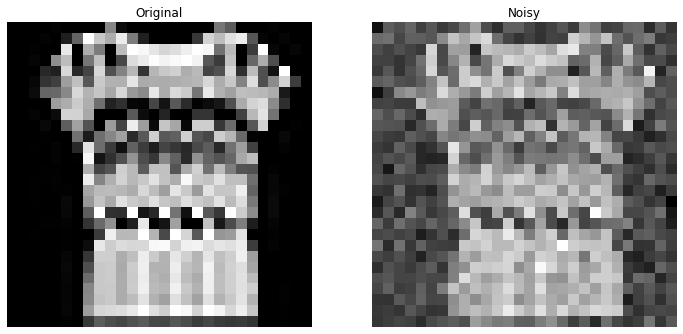

In [ ]:
def add_noise(inputs, noise_factor=0.3):
	noisy = inputs + torch.randn_like(inputs) * noise_factor
	# noisy = torch.clip(noisy,0.,1.)
	return noisy

for image_batch, _ in train_dataloader:
    
    # print('image_batch size:', image_batch.size())
    image_noisy = add_noise(image_batch, 0.3)

    figure = plt.figure(figsize=(12, 12))

    figure.add_subplot(1, 2, 1)
    plt.title(f'Original')
    plt.axis("off")
    plt.imshow(image_batch[0].squeeze(), cmap="gray")

    figure.add_subplot(1, 2, 2)
    plt.title(f'Noisy')
    plt.axis("off")
    plt.imshow(image_noisy[0].squeeze(), cmap="gray")

    plt.show()
    break

## **6. Model training**

To assess the quality of the reconstruction at each step, [MSE loss](https://pytorch.org/docs/stable/nn.html#torch.nn.MSELoss) is used.

In [ ]:
# Define an optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Neural network in training mode
model.train()

train_loss_avg = []
print('Training ...')

# Training loop
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:

        # Add noise to the image
        image_noisy = image_batch + torch.randn_like(image_batch) * noise_factor
        
        # Batch images to the device
        image_batch = image_batch.to(device)
        image_noisy = image_noisy.to(device)
       
        # Images reconstructed
        image_recontrs = model(image_noisy)
        
        # Evaluate loos score
        loss = F.mse_loss(image_recontrs, image_batch)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # Optimizer step (using the gradients computed by backpropagation)
        optimizer.step()

        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [1 / 50] average reconstruction error: 0.098140
Epoch [2 / 50] average reconstruction error: 0.063252
Epoch [3 / 50] average reconstruction error: 0.058453
Epoch [4 / 50] average reconstruction error: 0.055850
Epoch [5 / 50] average reconstruction error: 0.054048
Epoch [6 / 50] average reconstruction error: 0.052902
Epoch [7 / 50] average reconstruction error: 0.052013
Epoch [8 / 50] average reconstruction error: 0.051261
Epoch [9 / 50] average reconstruction error: 0.050773
Epoch [10 / 50] average reconstruction error: 0.050205
Epoch [11 / 50] average reconstruction error: 0.049812
Epoch [12 / 50] average reconstruction error: 0.049483
Epoch [13 / 50] average reconstruction error: 0.049103
Epoch [14 / 50] average reconstruction error: 0.048924
Epoch [15 / 50] average reconstruction error: 0.048719
Epoch [16 / 50] average reconstruction error: 0.048491
Epoch [17 / 50] average reconstruction error: 0.048333
Epoch [18 / 50] average reconstruction error: 0.048109
Epoch [19 / 50] ave

### Training curve

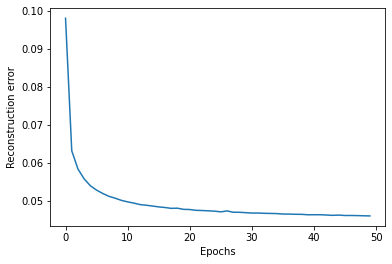

In [ ]:
fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

## **7. Model testing**

In [ ]:
# Neural network in evaluation mode
model.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:
    
    with torch.no_grad():
        
        image_noisy = image_batch + torch.randn_like(image_batch) * noise_factor

        image_batch = image_batch.to(device)
        image_noisy = image_noisy.to(device)

        image_recontrs = model(image_noisy)

        loss = F.mse_loss(image_recontrs, image_batch)
        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 0.047423


## **8. Visualizing reconstructions**

### Grid view

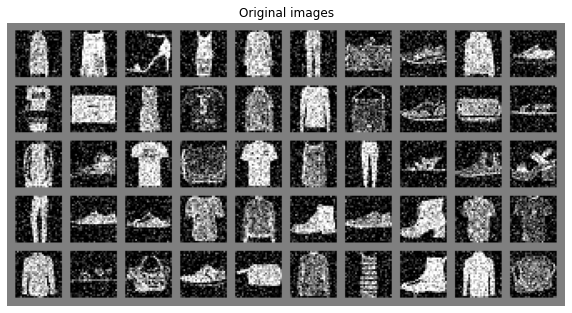

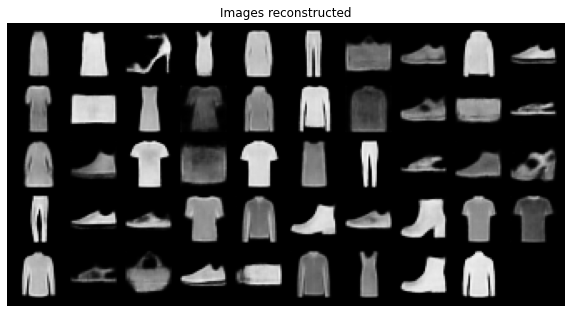

In [ ]:
model.eval()

# Funciones de graficación de las imagenes
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x


def show_image(img):
    img = to_img(img)
    npimg = img.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title('Original images')
    plt.axis("off")
    plt.show()


def visualise_output(images, model):
    with torch.no_grad():
        images = images.to(device)
        images = model(images)
        images = images.cpu()
        images = to_img(images)

        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()

        plt.figure(figsize=(10, 10))
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.title('Images reconstructed')
        plt.axis("off")
        plt.show()

# images, labels = iter(test_dataloader).next()
images, labels = next(iter(test_dataloader))
images = images + torch.randn_like(images) * noise_factor

show_image(torchvision.utils.make_grid(images[1:51], 10, 5))
visualise_output(images, model)

### Individual view

In [ ]:
images, labels = next(iter(test_dataloader))
images_noisy = images + torch.randn_like(images) * noise_factor

with torch.no_grad():
    images_input = images_noisy.to(device)
    image_recontrs = model(images_input)
    image_recontrs = image_recontrs.cpu()
    image_recontrs = to_img(image_recontrs)

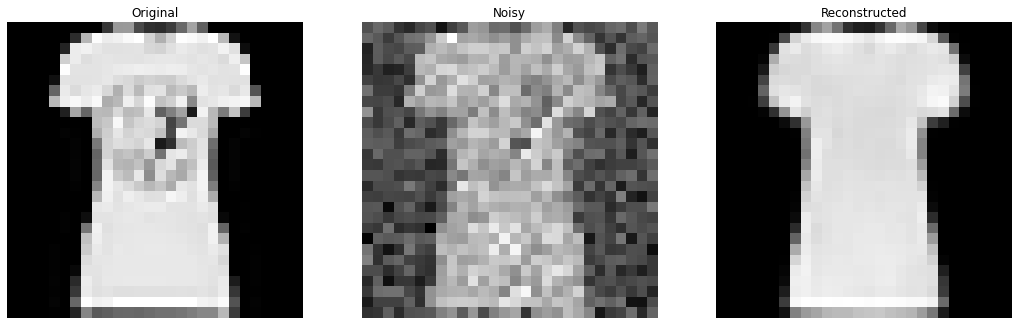

In [ ]:
figure = plt.figure(figsize=(18, 18))

sample_idx = torch.randint(len(images), size=(1,)).item()

figure.add_subplot(1, 3, 1)
plt.title(f'Original')
plt.axis("off")
plt.imshow(images[sample_idx].squeeze(), cmap="gray")

figure.add_subplot(1, 3, 2)
plt.title(f'Noisy')
plt.axis("off")
plt.imshow(images_noisy[sample_idx].squeeze(), cmap="gray")

figure.add_subplot(1, 3, 3)
plt.title(f'Reconstructed')
plt.axis("off")
plt.imshow(image_recontrs[sample_idx].squeeze(), cmap="gray")

plt.show()